# MNIST test file

## Description
Rotate and shift only one image of each category (number) and use it for training. Use <i>all the other images</i> in the dataset for testing.

Used for evaluating the functionality of the method for the fingerprints.

### Possible further development
<ul>
    <li>Compare results for different choices of training images.</li>
</ul>

### Previous results
#### Variation of sigma_rot
sigma rot | sigma u/d | n rots | n_estimators| mean score of 5 |
:--- | :--- | :--- | :--- | ---: |
10 | dim/10 | 100 | 100 | 0.5562460410068345 |
20 | dim/10 | 100 | 100 | 0.556752792132022 |
30 | dim/10 | 100 | 100 | 0.5230938489748291 |
40 | dim/10 | 100 | 100 | 0.5146291048508085 |
50 | dim/10 | 100 | 100 | 0.47648274712452077 |

Dim represents the dimension (IMG_SIZE&cross;) in each direction.

#### Variation of number of rotations
<i>Mean of 10 iterations. Sigma_rot=10</i><br>
List of number of rotations:
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]<br>
List of scores for those rotations:
[0.19895315885980996, 0.43563260543423893, 0.4889448241373563, 0.5130121686947824, 0.5197799633272211, 0.5345240873478914, 0.5372195365894317, 0.548588098016336, 0.5464510751791966, 0.5576812802133688, 0.5546574429071511]

<i>Mean of 5 iterations. Sigma_rot=20</i><br>
List of number of rotations:
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]<br>
List of scores for those rotations:
[0.1932022003667278, 0.36534422403733957, 0.4460810135022504, 0.5098649774962494, 0.49379563260543424, 0.5250175029171529, 0.5375629271545257, 0.5452342057009502, 0.533478913152192, 0.5602567094515754, 0.5606334389064844, 0.5716852808801467, 0.5778396399399901, 0.5768828138023003, 0.58864144024004, 0.5925754292382064, 0.5920653442240373, 0.5977929654942491, 0.5879479913318887, 0.5953258876479414, 0.5946857809634938, 0.6003567261210202, 0.6011568594765795, 0.5987997999666611, 0.6001500250041675, 0.5977329554925821]

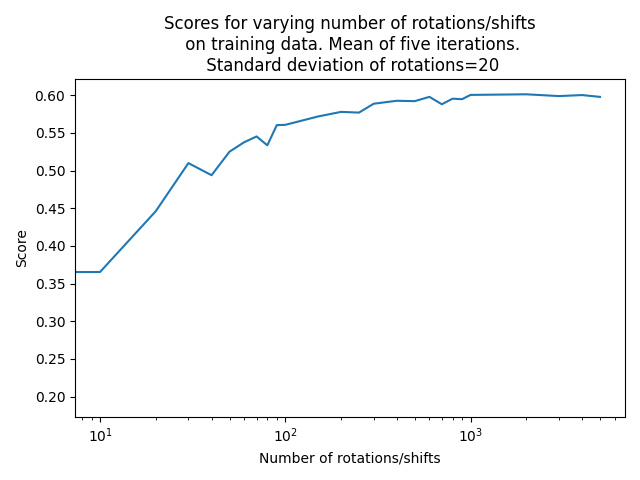

## The code

### Imports

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from sklearn.datasets import load_digits
from mnist import MNIST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn

### Functions

In [2]:
def my_train_test_split(df):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(df)):
        data = df.iloc[i]
        if data[1] in y_train:
            X_test.append(data[0])
            y_test.append(data[1])
        else:
            X_train.append(data[0])
            y_train.append(data[1])
    return X_train, y_train, X_test, y_test

In [3]:
def crop_center(img):
    dim0, dim1 = img.shape
    x0 = (dim0-IMG_SIZE0)//2
    x1 = (dim1-IMG_SIZE1)//2
    if dim0 < IMG_SIZE0:
        cropped_img = np.ones((IMG_SIZE0,IMG_SIZE1))*0
        dim1_crop = img[:,x1:x1+IMG_SIZE1]
        cropped_img[:dim0,:] = dim1_crop # Put image to the left. Possible source of error
    else:
        cropped_img = img[x0:x0+IMG_SIZE0,x1:x1+IMG_SIZE1]
    return cropped_img

In [4]:
def rotate_image(img):
    # Constants
    shift0 = int(rnd.gauss(0,IMG_SIZE0/10)) # The choice of random function should perhaps be reconsidered
    shift1 = int(rnd.gauss(0,IMG_SIZE1/10))
    deg = rnd.gauss(0,SIGMA_ROT) # Uncomment for gaussian distribution
    # deg = rnd.uniform(0,360) # Uncomment for uniform distribution
    # Necessary modification
    img = np.reshape(img, (IMG_SIZE0,IMG_SIZE1)) # If the input array is flattened
    # Transform the image
    new_img = ndimage.rotate(img, deg, reshape=True, cval=0) # cval gives value to fill added edges with
    new_img = ndimage.shift(new_img, [shift0, shift1], cval=0)
    new_img = crop_center(new_img)
    # plt.imshow(new_img, cmap="gray") # Uncomment to see image
    new_img = new_img.flatten() # Comment out if array should not be flattened
    return new_img

In [5]:
def extend_training_set(X_train,y_train):
    X_train_new = []
    y_train_new = []
    for i in range(len(X_train)):
        y_train_new.extend([y_train[i]]*(N_ROTATIONS+1))
        for j in range(N_ROTATIONS+1):
            X_train_new.append(rotate_image(X_train[i]))
    return X_train_new, y_train_new

## Implementation

In [6]:
# Constants
N_ROTATIONS = 5 # Number of rotations per image
SIGMA_ROT = 20
IMG_SIZE0 = 28
IMG_SIZE1 = 28

In [7]:
# Load data and store in DataFrame
mndata = MNIST("MNIST")
images,labels = mndata.load_training()
df=pd.DataFrame()
df["Images"]=images
df["Target"]=labels

In [8]:
# Split data into train and test sets
X_train, y_train, X_test, y_test = my_train_test_split(df)

In [9]:
# Prepare the model
model = RandomForestClassifier(n_estimators=100) # Larger n_estimators takes longer to calculate

In [13]:
# Final work
X_train_new, y_train_new = extend_training_set(X_train, y_train)
model.fit(X_train_new,y_train_new)
model.score(X_test,y_test)

0.14297382897149524

#### Compare different numbers of rotations

In [18]:
iterations = 5
scores_list = []
nrot_list = list(range(0,101,10))
for nrot in nrot_list:
    N_ROTATIONS = nrot
    sumscores = 0
    for i in range(iterations):
        X_train_new, y_train_new = extend_training_set(X_train, y_train)
        model.fit(X_train_new,y_train_new)
        sumscores+=model.score(X_test,y_test)
    scores_list.append(sumscores/iterations)

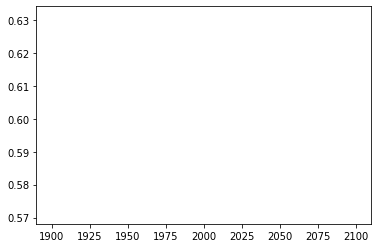

In [12]:
plt.figure()
plt.plot(nrot_list, scores_list)

In [20]:
print(nrot_list)
print(scores_list)

[5000]
[0.5977329554925821]


### Confusion matrix
(not vital, but perhaps a bit fun to see)

Text(33.0, 0.5, 'Truth')

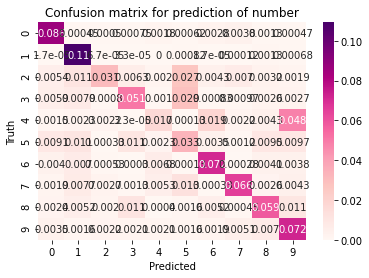

In [99]:
# Predict class for X.
y_predicted = model.predict(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_predicted, normalize='all') # Remove 'normalize="all"' to get absolute numbers
plt.figure()
sn.heatmap(cm, annot=True, cmap='RdPu')
plt.title('Confusion matrix for prediction of number')
plt.xlabel('Predicted')
plt.ylabel('Truth')